# AWS Deep Racer
Susan Catanoso
Summer 2019
DSSA-5302 Data Practicum

AWS DeepRacer provides code samples for analyzing and debugging AWS DeepRacer simulation log files so that you can improve your model.

https://aws.amazon.com/deepracer/racing-tips/

https://github.com/aws-samples/aws-deepracer-workshops/tree/master/log-analysis/

Based on the AWS github code and models I generated, this notebook will create visualizations to see how well the models performed.

# Requirements
boto3 >= 1.9.133 ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

from datetime import datetime
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
# Import functions from AWS python files copied into my .ipynb folder location so the Jupyter Notebook can access the DeepRacer log files on AWS
# AWS credentials had to previously be set up in order for these to run
from log_analysis import *
import cw_utils

In [4]:
# Make sure your boto version is >= '1.9.133'
cw_utils.boto3.__version__

'1.9.197'

# Download the simulation log data from AWS DeepRacer logs in Cloudwatch

The first model to look at is the model trained on the AWS track

In [5]:
stream_name = 'sim-5yt0f55lfpcd' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the AWS track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


## AWS CLI can be used to inspect the data files

In [6]:
!tail -n 7 $fname                

SIM_TRACE_LOG:1279,106,8.9174,1.0438,-0.6697,0.52,8.00,20,0.5400,False,True,10.5523,17,69.25,1563783626.511921
SIM_TRACE_LOG:1279,107,9.0210,0.9630,-0.6657,-0.17,2.67,6,0.0000,False,False,10.7017,17,69.25,1563783626.5704072
SIM_TRACE_LOG:1279,108,9.1089,0.8916,-0.6749,-0.35,2.67,3,0.0000,False,False,10.8287,17,69.25,1563783626.634832
SIM_TRACE_LOG:1279,109,9.1791,0.8283,-0.7053,-0.17,8.00,8,0.0000,False,False,10.9300,18,69.25,1563783626.7212968
SIM_TRACE_LOG:1279,110,9.2609,0.7493,-0.7421,-0.35,8.00,5,0.0000,False,False,11.0481,18,69.25,1563783626.7688074
SIM_TRACE_LOG:1279,111,9.3344,0.6688,-0.7906,0.17,2.67,12,0.0000,True,False,11.1541,18,69.25,1563783626.8348103
Training> Name=main_level/agent, Worker=0, Episode=1280, Total reward=187.2, Steps=74027, Training iteration=0


# Load waypoints for the track you want to run analysis on
## Tracks Available:
- AWS_track 
- Straight_track 
- Oval_track
- Bowtie_track 
- H_track  
- reinvent_base
- London_Loop_Train
- Tokyo_Training_track

In [7]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_AWS = get_track_waypoints("AWS_track") # Fill in track name from above
waypoints_AWS.shape

(302, 6)

# Visualize the Track

This shows the shape of the track used for training

In [8]:
l_center_line = LineString(waypoints_AWS[:,0:2])
l_inner_border = LineString(waypoints_AWS[:,2:4])
l_outer_border = LineString(waypoints_AWS[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

# Load the training data

In [9]:
data_AWS = load_data(fname)

In [10]:
df_AWS = convert_to_pandas(data_AWS, None)
df_AWS.head()

iteration  episode  steps       x       y     yaw  steer  throttle  action  \
0          1        0      0  521.23  117.75  0.0111   0.00      0.00     0.0   
1          1        0      1  521.25  117.75  0.0108   0.52      5.33    19.0   
2          1        0      2  521.42  117.75  0.0088   0.00      8.00    11.0   
3          1        0      3  521.94  117.69  0.0002  -0.35      8.00     5.0   
4          1        0      4  522.97  117.43 -0.0272  -0.35      5.33     4.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.2022                 1      69.25   
1    2.20     0     True    0.2025                 1      69.25   
2    2.75     0     True    0.2048                 1      69.25   
3    2.75     0     True    0.2125                 1      69.25   
4    2.75     0     True    0.2273                 1      69.25   

            timestamp  
0   1563772945.422766  
1   1563772945.533205  
2  1563772945.5862772  
3  1563772945.6448028  
4  1563772945.7167044

In [11]:
df_AWS['y'].min(), df_AWS['y'].max()

(55.21, 1101.42)

In [12]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_AWS['reward'].values.reshape(df_AWS['reward'].values.shape[0], 1))
df_AWS['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [13]:
df_AWS['reward'].min(), df_AWS['reward'].max()

(0.0, 1.0)

In [14]:
df_AWS.to_csv('AWS.csv')         # Save the data for later use

# Track Plotting Functions

These functions are called in subsequent Notebook chunks

In [15]:
def plot_track(df, track_size=(1200, 2200), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
    
    track = np.zeros(track_size)              # create an array of the track size full of zeros
    for index, row in df.iterrows():          # populate the array with the x, y and reward values from the track log dataframe
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_AWS, inner_border_AWS, outer_border_AWS)    # prints the data plus the track outline (center_line, inner_border, outer_border)
    return track

# Analyze the reward distribution for the reward function

This graph shows the locations on the track where rewards were earned.  The intensity of the dot shows how many were earned in that spot.

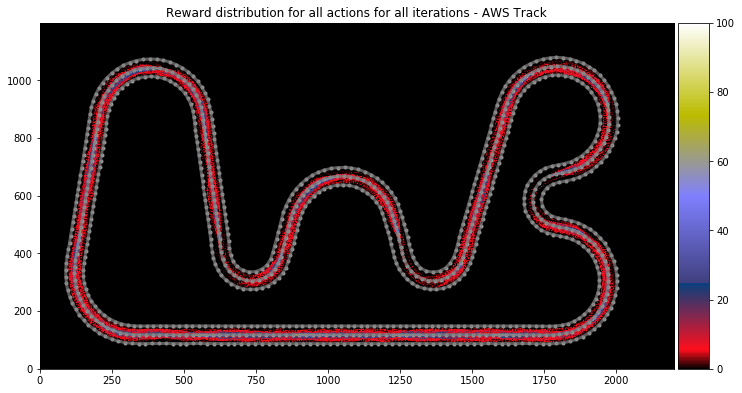

In [16]:
             # identify and rescale waypoints to centimeter scale
center_line_AWS = waypoints_AWS[:,0:2] *100
inner_border_AWS = waypoints_AWS[:,2:4] *100
outer_border_AWS = waypoints_AWS[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_AWS['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
else:
    y_offset = abs(y_offset)
center_line_AWS[:,1] = center_line_AWS[:,1] + y_offset
inner_border_AWS[:,1] = inner_border_AWS[:,1] + y_offset
outer_border_AWS[:,1] = outer_border_AWS[:,1] + y_offset

track = plot_track(df_AWS)
plt.title("Reward distribution for all actions for all iterations - AWS Track")
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    return fig.colorbar(mappable, cax=cax
                       )

img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)


# From the graph below, it seems that the reward level is fairly consistent throughout the track with the exception of turning to the right.
# The model is not gaining many rewards when that happens so it needs to be improved to handle this turn direction better.  
# Rewards don't seem to be high anywhere along the track.

# Plot a specific iteration

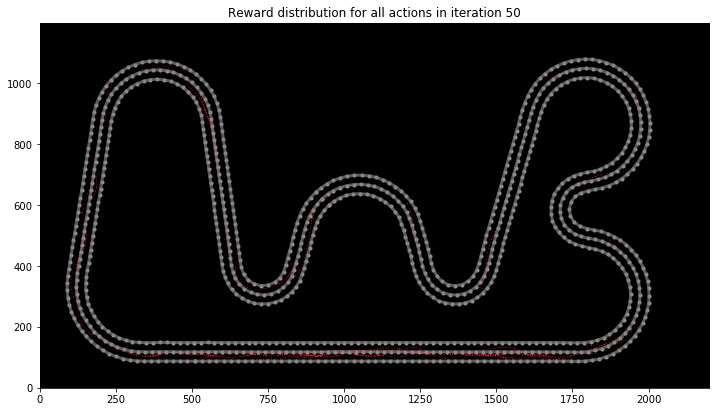

In [17]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_AWS[df_AWS['iteration'] == iteration_id])
plt.title("Reward distribution for all actions in iteration " + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model hyperparameter).  
# You can see where the rewards were earned by the red dots.  Mostly along the bottom straightaway and then around several of the turns.

# Plot rewards per iteration

This helps to understand the mean reward and standard deviation with each iteration

Number of episodes =  1279


Text(0.5, 0, 'Episode')

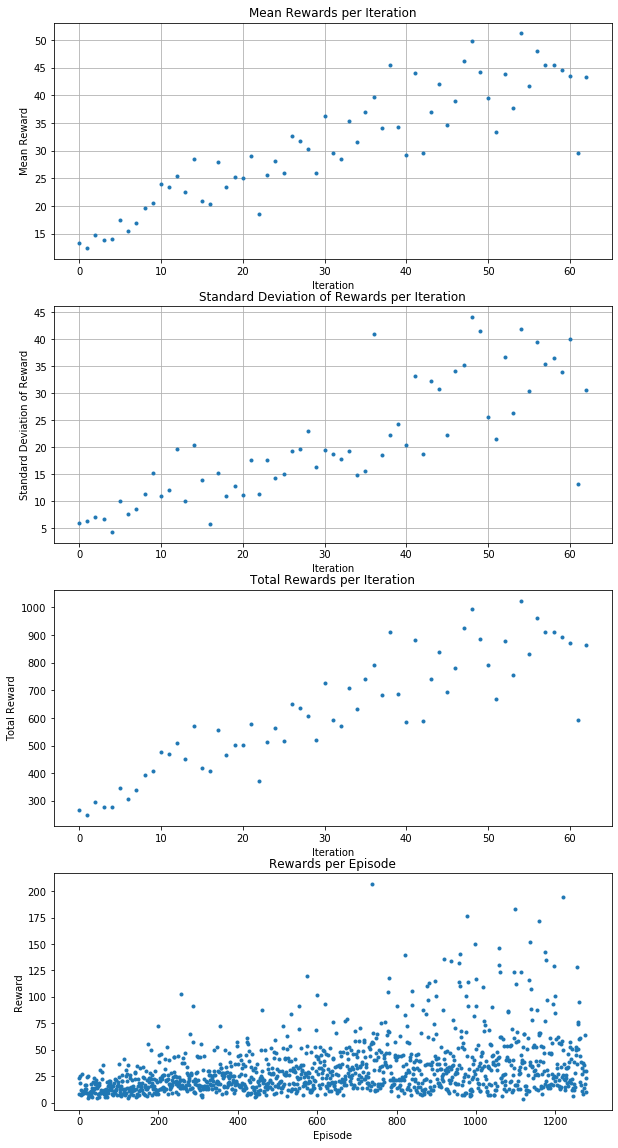

In [18]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_AWS['episode'])
max_episodes = np.max(df_AWS['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_AWS[df_AWS['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

# Rewards are increasing so the model is continuing to learn.

# Path taken 

In a single episode, the car will go until it completes the track or falls off the track.  The following plots the episodes that received the three highest rewards

In [19]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_AWS)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_AWS)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_AWS)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'g.')
        
    return fig

In [20]:
action_map, episode_map, sorted_idx = episode_parser(data_AWS) 
fig = plot_top_laps(sorted_idx[:], 3)
# None of the model's highest reward earning episodes completed the track.

# Path taken in a particular episode

In [21]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_AWS, inner_border_AWS, outer_border_AWS) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

In [22]:
plot_episode_run(df_AWS, E=900) # arbitrary episode that was selected
                             # based on training time for my models, I selected a high number
                             # Demonstrates that you can drill down to a granular level to see how/where the car leaves the track.

# Path taken in a particular iteration

In [23]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_AWS, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


# Track Analysis
Analyze the behavior in the lap by episode to see what has happened with the speed.

Understand the speed of the car along with the path on a per episode basis.  This can help debug portions of the track where the car may not be going fast giving you hints on how to improve the reward function.

Episode #750 
400 215
Outer polygon length = 284.47 (meters)
Inner polygon length = 269.10 (meters)
Distance, lap time = 2.01 (meters), 1.84 (sec)
Average throttle, velocity = 4.76 (Gazebo), 1.09 (meters/sec)
###############################################################


Episode #751 
400 215
Outer polygon length = 284.47 (meters)
Inner polygon length = 269.10 (meters)
Distance, lap time = 9.14 (meters), 8.86 (sec)
Average throttle, velocity = 4.09 (Gazebo), 1.03 (meters/sec)
###############################################################


Episode #752 
400 215
Outer polygon length = 284.47 (meters)
Inner polygon length = 269.10 (meters)
Distance, lap time = 6.07 (meters), 5.53 (sec)
Average throttle, velocity = 4.03 (Gazebo), 1.10 (meters/sec)
###############################################################




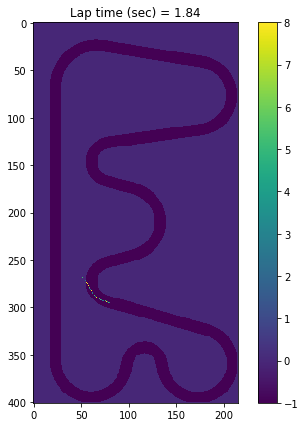

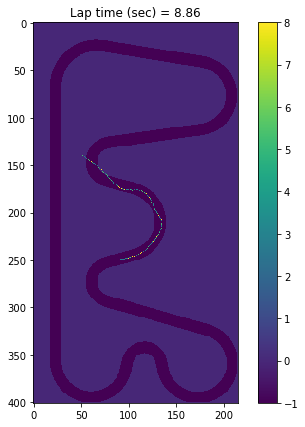

In [24]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_AWS[df_AWS['episode'] == e]
    plot_grid_world(episode_df, inner_border_AWS, outer_border_AWS, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  The car resumes training in each new episode at or near where it left the track in the prior episode.

# Rerun the above code for the Oval Model


In [25]:
stream_name = 'sim-1r8w6c73j2xk' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the Oval track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


In [26]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_oval = get_track_waypoints("Oval_track") # Fill in track name from above
waypoints_oval.shape

(102, 6)

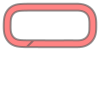

In [27]:
l_center_line = LineString(waypoints_oval[:,0:2])
l_inner_border = LineString(waypoints_oval[:,2:4])
l_outer_border = LineString(waypoints_oval[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [28]:
data_oval = load_data(fname)

In [29]:
df_oval = convert_to_pandas(data_oval, None)
df_oval.head()

iteration  episode  steps       x      y     yaw  steer  throttle  action  \
0          1        0      0  311.32  95.82 -0.0037   0.00      0.00     0.0   
1          1        0      1  311.32  95.82 -0.0036  -0.35      2.67     3.0   
2          1        0      2  311.67  95.70 -0.0117  -0.35      2.67     3.0   
3          1        0      3  312.42  95.12 -0.0521  -0.35      8.00     5.0   
4          1        0      4  313.90  93.95 -0.1252  -0.17      2.67     6.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.7162                 1      19.55   
1    2.75     0     True    0.7167                 1      19.55   
2    2.75     0     True    0.7344                 1      19.55   
3    2.75     0     True    0.7728                 1      19.55   
4    2.75     0     True    0.8487                 1      19.55   

            timestamp  
0  1563760683.7419498  
1  1563760683.8660681  
2  1563760683.9050481  
3  1563760683.9489465  
4  1563760684.0143344

In [30]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_oval['reward'].values.reshape(df_oval['reward'].values.shape[0], 1))
df_oval['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [31]:
df_oval['reward'].min(), df_oval['reward'].max()

(0.0, 1.0)

In [32]:
df_oval.to_csv("oval.csv")         # Save the data for later use

In [33]:
def plot_track(df, track_size=(500, 950), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
   
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_oval, inner_border_oval, outer_border_oval)
    return track

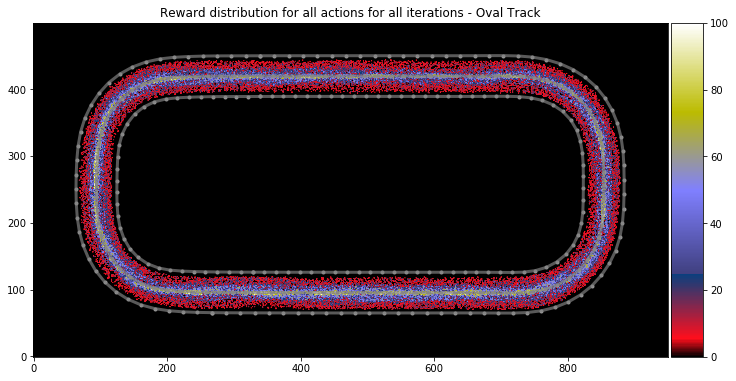

In [34]:
             # identify and rescale waypoints to centimeter scale
center_line_oval = waypoints_oval[:,0:2] *100
inner_border_oval = waypoints_oval[:,2:4] *100
outer_border_oval = waypoints_oval[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_oval['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
else:
    y_offset = abs(y_offset)
center_line_oval[:,1] = center_line_oval[:,1] + y_offset
inner_border_oval[:,1] = inner_border_oval[:,1] + y_offset
outer_border_oval[:,1] = outer_border_oval[:,1] + y_offset

track = plot_track(df_oval)
plt.title("Reward distribution for all actions for all iterations - Oval Track")
img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)

# From the graph below, it seems that the reward level is fairly consistent throughout the track.  The car was able to stay on the center line and gain a lot of rewards by doing so.

In [35]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_oval[df_oval['iteration'] == iteration_id])
plt.title("Reward distribution for all actions in iteration " + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model hyperparameter).  
# You can see where the rewards were earned by the red dots.  

In [36]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_oval)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_oval)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_oval)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'g.')
        
    return fig

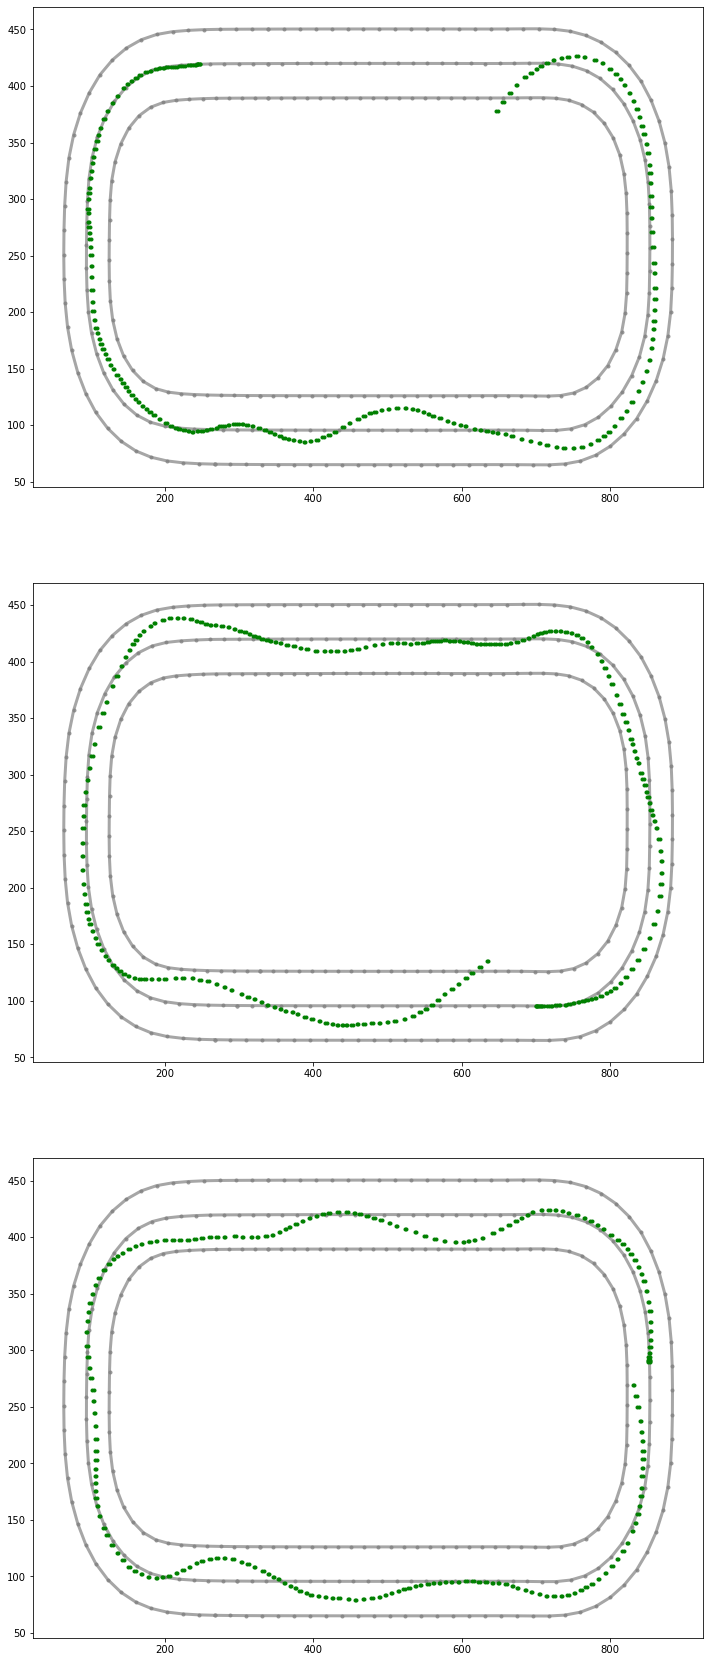

In [37]:
action_map, episode_map, sorted_idx = episode_parser(data_oval) 
fig = plot_top_laps(sorted_idx[:], 3)
# None of the model's highest reward earning episodes completed the track. Two came close.

Number of episodes =  1370


Text(0.5, 0, 'Episode')

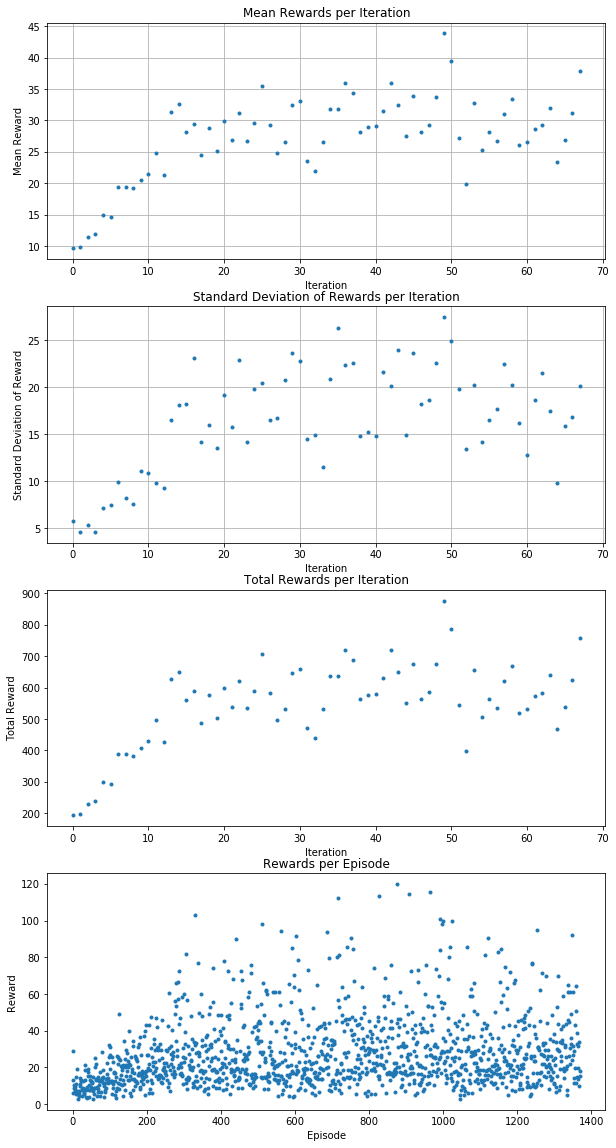

In [38]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_oval['episode'])
max_episodes = np.max(df_oval['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_oval[df_oval['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

In [39]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_oval, inner_border_oval, outer_border_oval) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

In [40]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_oval, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Episode #750 
176 90
Outer polygon length = 85.79 (meters)
Inner polygon length = 70.50 (meters)
Distance, lap time = 6.77 (meters), 5.63 (sec)
Average throttle, velocity = 4.48 (Gazebo), 1.20 (meters/sec)
###############################################################


Episode #751 
176 90
Outer polygon length = 85.79 (meters)
Inner polygon length = 70.50 (meters)
Distance, lap time = 4.76 (meters), 3.45 (sec)
Average throttle, velocity = 5.08 (Gazebo), 1.38 (meters/sec)
###############################################################


Episode #752 
176 90
Outer polygon length = 85.79 (meters)
Inner polygon length = 70.50 (meters)
Distance, lap time = 13.97 (meters), 11.39 (sec)
Average throttle, velocity = 4.61 (Gazebo), 1.23 (meters/sec)
###############################################################




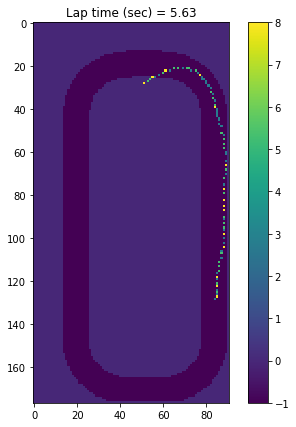

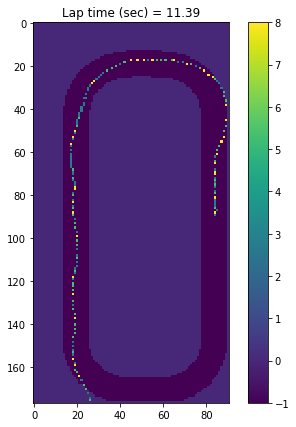

In [41]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_oval[df_oval['episode'] == e]
    plot_grid_world(episode_df, inner_border_oval, outer_border_oval, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  The car resumes training in each new episode at or near where it left the track in the prior episode
# or at the beginning if it went too far off the track.

# Rerun the above code for the Bowtie Model

In [42]:
stream_name = 'sim-fl4w73fkmk34' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the Bowtie track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


In [43]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_bowtie = get_track_waypoints("Bowtie_track") # Fill in track name from above
waypoints_bowtie.shape

(163, 6)

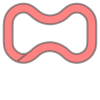

In [44]:
l_center_line = LineString(waypoints_bowtie[:,0:2])
l_inner_border = LineString(waypoints_bowtie[:,2:4])
l_outer_border = LineString(waypoints_bowtie[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [45]:
data_bowtie = load_data(fname)

In [46]:
df_bowtie = convert_to_pandas(data_bowtie, None)
df_bowtie.head()

iteration  episode  steps       x      y     yaw  steer  throttle  action  \
0          1        0      0  222.46  87.19  0.0090   0.00      0.00     0.0   
1          1        0      1  222.49  87.19  0.0084   0.17      8.00    14.0   
2          1        0      2  222.80  87.11  0.0012  -0.52      8.00     2.0   
3          1        0      3  223.66  86.64 -0.0322  -0.52      2.67     0.0   
4          1        0      4  225.47  85.11 -0.1334  -0.52      8.00     2.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.8021                 1      17.43   
1    2.75     0     True    0.8037                 1      17.43   
2    2.20     0     True    0.8209                 1      17.43   
3    2.20     0     True    0.8662                 1      17.43   
4    1.10     0     True    0.9583                 2      17.43   

            timestamp  
0  1563760603.0897336  
1  1563760603.1917155  
2  1563760603.2347333  
3   1563760603.288768  
4  1563760603.3649294

In [47]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_bowtie['reward'].values.reshape(df_bowtie['reward'].values.shape[0], 1))
df_bowtie['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [48]:
df_bowtie['reward'].min(), df_bowtie['reward'].max()

(0.0, 1.0)

In [49]:
df_bowtie.to_csv("bowtie.csv")        #Save file for later

In [50]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
    
    track = np.zeros(track_size)             
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_bowtie, inner_border_bowtie, outer_border_bowtie)
    return track

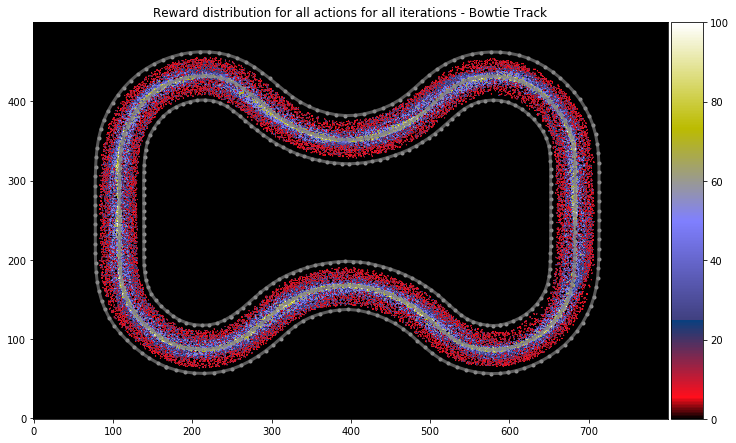

In [51]:
             # identify and rescale waypoints to centimeter scale
center_line_bowtie = waypoints_bowtie[:,0:2] *100
inner_border_bowtie = waypoints_bowtie[:,2:4] *100
outer_border_bowtie = waypoints_bowtie[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_bowtie['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
else:
    y_offset = abs(y_offset)
center_line_bowtie[:,1] = center_line_bowtie[:,1] + y_offset
inner_border_bowtie[:,1] = inner_border_bowtie[:,1] + y_offset
outer_border_bowtie[:,1] = outer_border_bowtie[:,1] + y_offset

track = plot_track(df_bowtie)
plt.title("Reward distribution for all actions for all iterations - Bowtie Track")
img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)

# None of the turns on this track are sharp turns.  Its reward distribution is similar to the oval track.
# From the graph below, it seems that the reward level has three intensities - red, purple and white.
# They seem to be fairly consistent with more being earned on the center line.

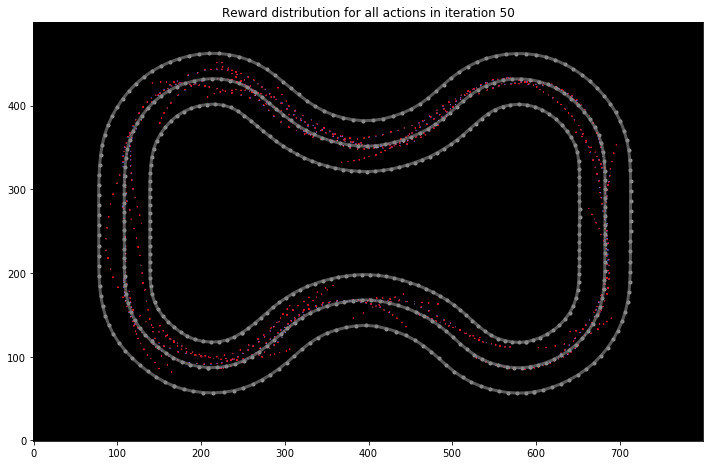

In [52]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_bowtie[df_bowtie['iteration'] == iteration_id])
plt.title("Reward distribution for all actions in iteration " + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model hyperparameter).  
# You can see where the rewards were earned by the red dots.  

In [53]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_bowtie)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_bowtie)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_bowtie)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'g.')
        
    return fig

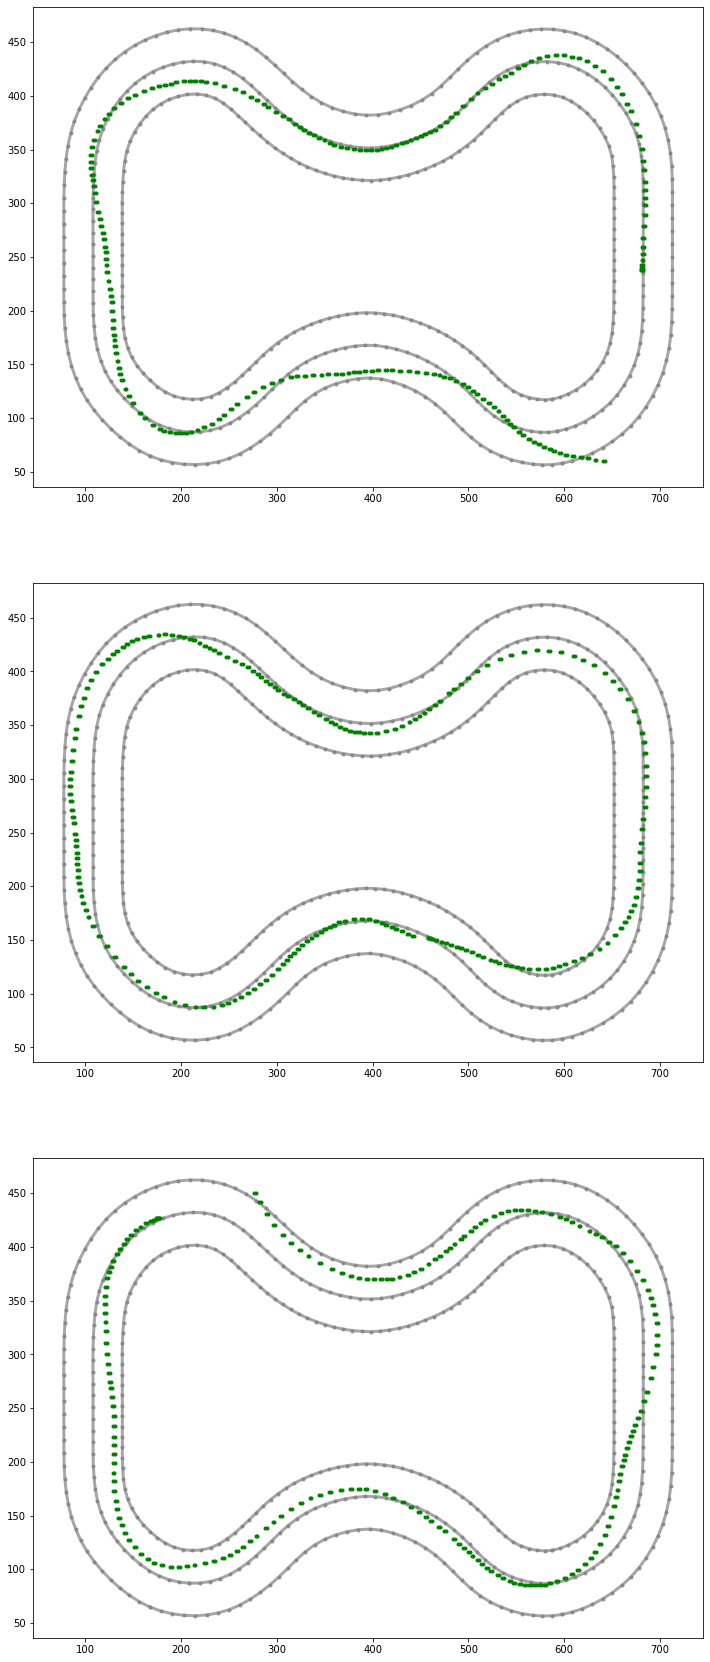

In [54]:
action_map, episode_map, sorted_idx = episode_parser(data_bowtie) 
fig = plot_top_laps(sorted_idx[:], 3)
# One of the model's highest reward earning episodes completed the track.

Number of episodes =  1639


Text(0.5, 0, 'Episode')

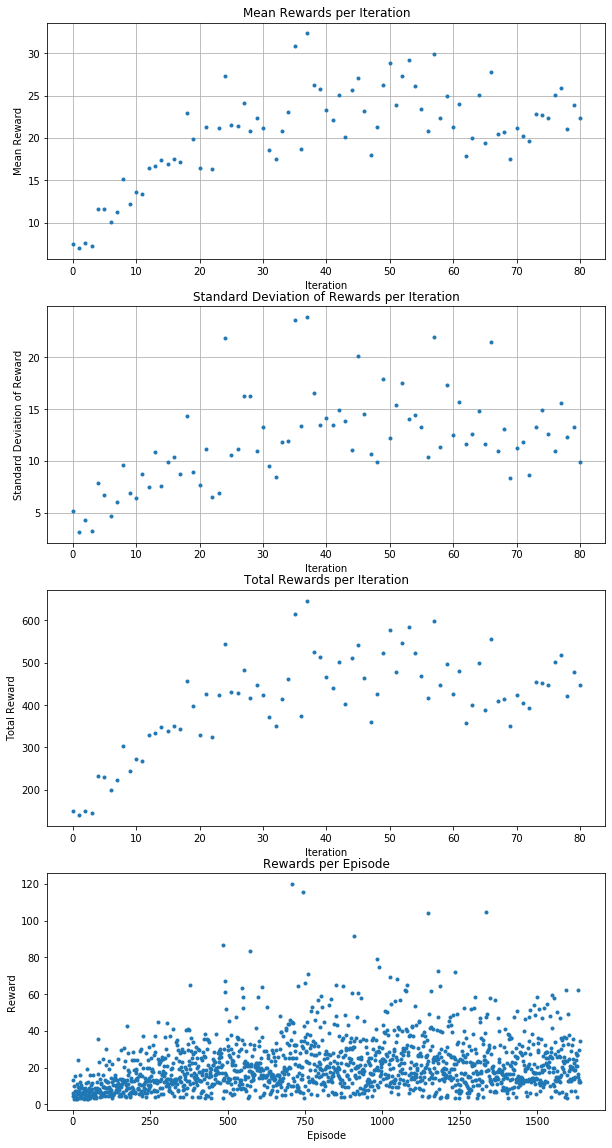

In [55]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_bowtie['episode'])
max_episodes = np.max(df_bowtie['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_bowtie[df_bowtie['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

In [56]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_bowtie, inner_border_bowtie, outer_border_bowtie) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


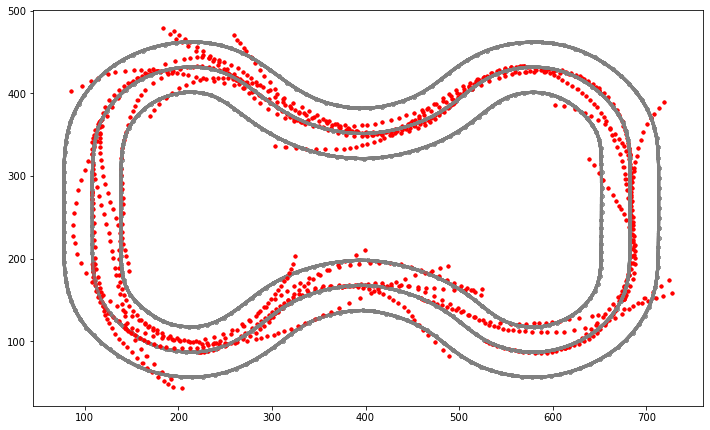

In [57]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_bowtie, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

Episode #750 
142 92
Outer polygon length = 77.32 (meters)
Inner polygon length = 62.03 (meters)
Distance, lap time = 1.62 (meters), 1.69 (sec)
Average throttle, velocity = 4.21 (Gazebo), 0.96 (meters/sec)
###############################################################


Episode #751 
142 92
Outer polygon length = 77.32 (meters)
Inner polygon length = 62.03 (meters)
Distance, lap time = 4.41 (meters), 4.63 (sec)
Average throttle, velocity = 3.71 (Gazebo), 0.95 (meters/sec)
###############################################################


Episode #752 
142 92
Outer polygon length = 77.32 (meters)
Inner polygon length = 62.03 (meters)
Distance, lap time = 3.30 (meters), 3.11 (sec)
Average throttle, velocity = 4.37 (Gazebo), 1.06 (meters/sec)
###############################################################




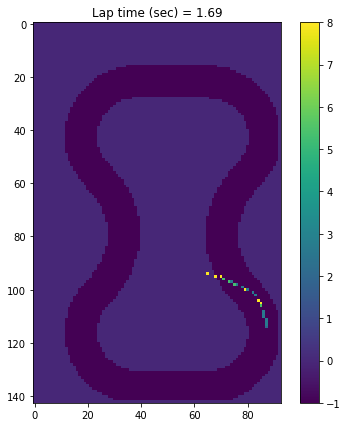

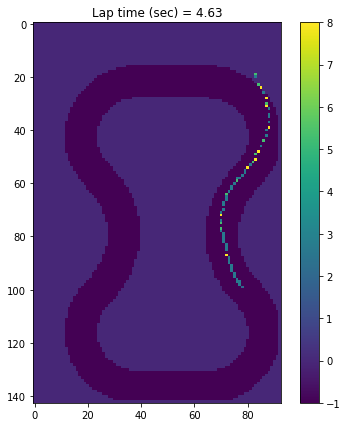

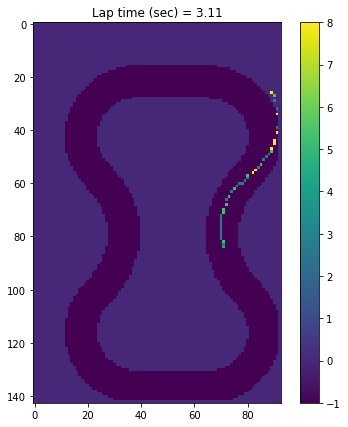

In [58]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_bowtie[df_bowtie['episode'] == e]
    plot_grid_world(episode_df, inner_border_bowtie, outer_border_bowtie, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  

# Rerun the above code for the London Model

In [59]:
stream_name = 'sim-jcjxhwg4vvhd' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the London Loop track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


In [60]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_London = get_track_waypoints("London_Loop_Train") # Fill in track name from above
waypoints_London.shape

(214, 6)

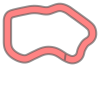

In [61]:
l_center_line = LineString(waypoints_London[:,0:2])
l_inner_border = LineString(waypoints_London[:,2:4])
l_outer_border = LineString(waypoints_London[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [62]:
data_London = load_data(fname)

In [63]:
df_London = convert_to_pandas(data_London, None)
df_London.head()

iteration  episode  steps       x      y     yaw  steer  throttle  action  \
0          1        0      0  532.71  53.11 -0.4753   0.00      0.00     0.0   
1          1        0      1  532.79  53.10 -0.4737   0.35      8.00    17.0   
2          1        0      2  532.95  53.02 -0.4730  -0.52      5.33     1.0   
3          1        0      3  533.64  52.72 -0.4740  -0.52      2.67     0.0   
4          1        0      4  534.86  52.12 -0.4745  -0.17      5.33     7.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.7207                 2      19.45   
1    2.75     0     True    0.7245                 2      19.45   
2    2.20     0     True    0.7339                 2      19.45   
3    2.20     0     True    0.7724                 2      19.45   
4    2.75     0     True    0.8423                 2      19.45   

            timestamp  
0  1563760494.2963307  
1   1563760494.405949  
2  1563760494.4422371  
3  1563760494.5203288  
4  1563760494.5942888

In [64]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_London['reward'].values.reshape(df_London['reward'].values.shape[0], 1))
df_London['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [65]:
df_London['reward'].min(), df_London['reward'].max()

(0.0, 1.0)

In [66]:
df_London.to_csv("London.csv")     #Save file for later

In [69]:
def plot_track(df, track_size=(600, 825), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
    
    track = np.zeros(track_size) 
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_London, inner_border_London, outer_border_London)
    return track

### DO NOT RUN

track = plot_track(df, track_size=(600,825), x_offset=0, y_offset=y_offset)    #Note - for this track, need to pass all parameters
plt.title("Reward distribution for all actions for all iterations")
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
# From the graph below, it seems that the reward level is fairly consistent throughout the track with the exception of turning to the right.
# The model is not gaining many rewards when that happens.

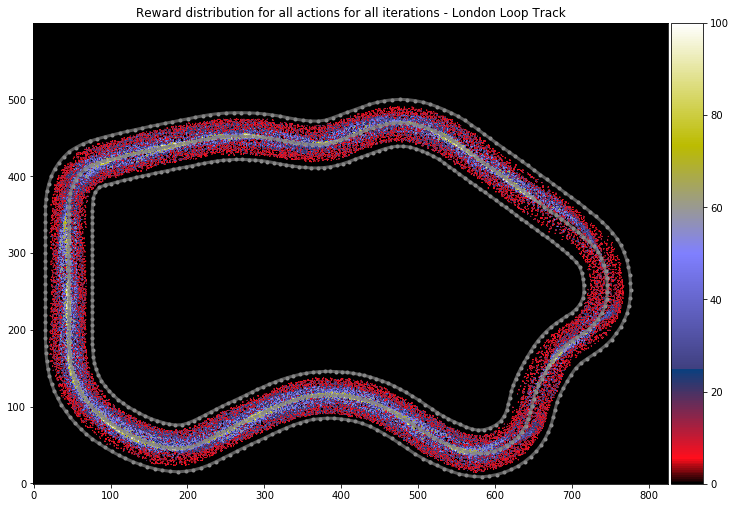

In [70]:
             # identify and rescale waypoints to centimeter scale
center_line_London = waypoints_London[:,0:2] *100
inner_border_London = waypoints_London[:,2:4] *100
outer_border_London = waypoints_London[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_London['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
else:
    y_offset = abs(y_offset)
#center_line_London[:,1] = center_line_London[:,1] + y_offset
#inner_border_London[:,1] = inner_border_London[:,1] + y_offset
#outer_border_London[:,1] = outer_border_London[:,1] + y_offset

track = plot_track(df_London)
plt.title("Reward distribution for all actions for all iterations - London Loop Track")
img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)
# From the graph below, it seems that the reward level is fairly consistent throughout the track with the
# exception of the lower right hand portion of the track..
# The model is not gaining many rewards when that happens.  Its rewards are concentrated on the center line.
# From the graph below, it seems that the reward level has three intensities - red, purple and white.
# They seem to be fairly consistent with more being earned on the center line.

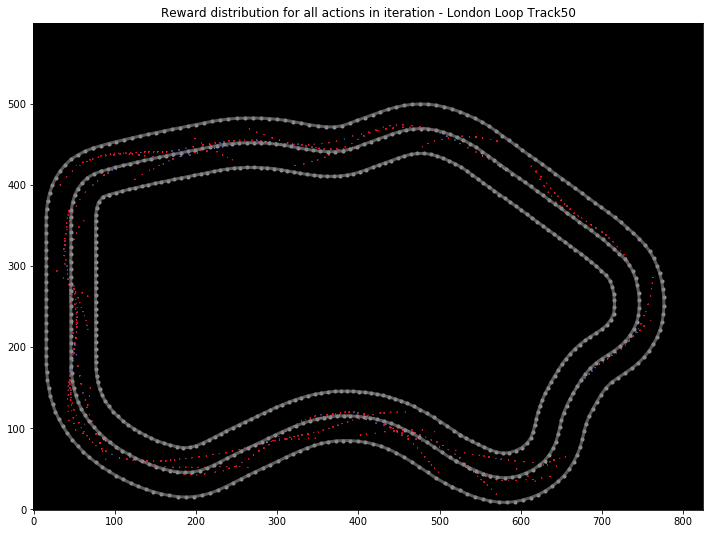

In [71]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_London[df_London['iteration'] == iteration_id])
plt.title("Reward distribution for all actions in iteration - London Loop Track" + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model  hyperparameter).  
# You can see where the rewards were earned by the red dots. 

In [72]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_London)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_London)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_London)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'g.')
        
    return fig

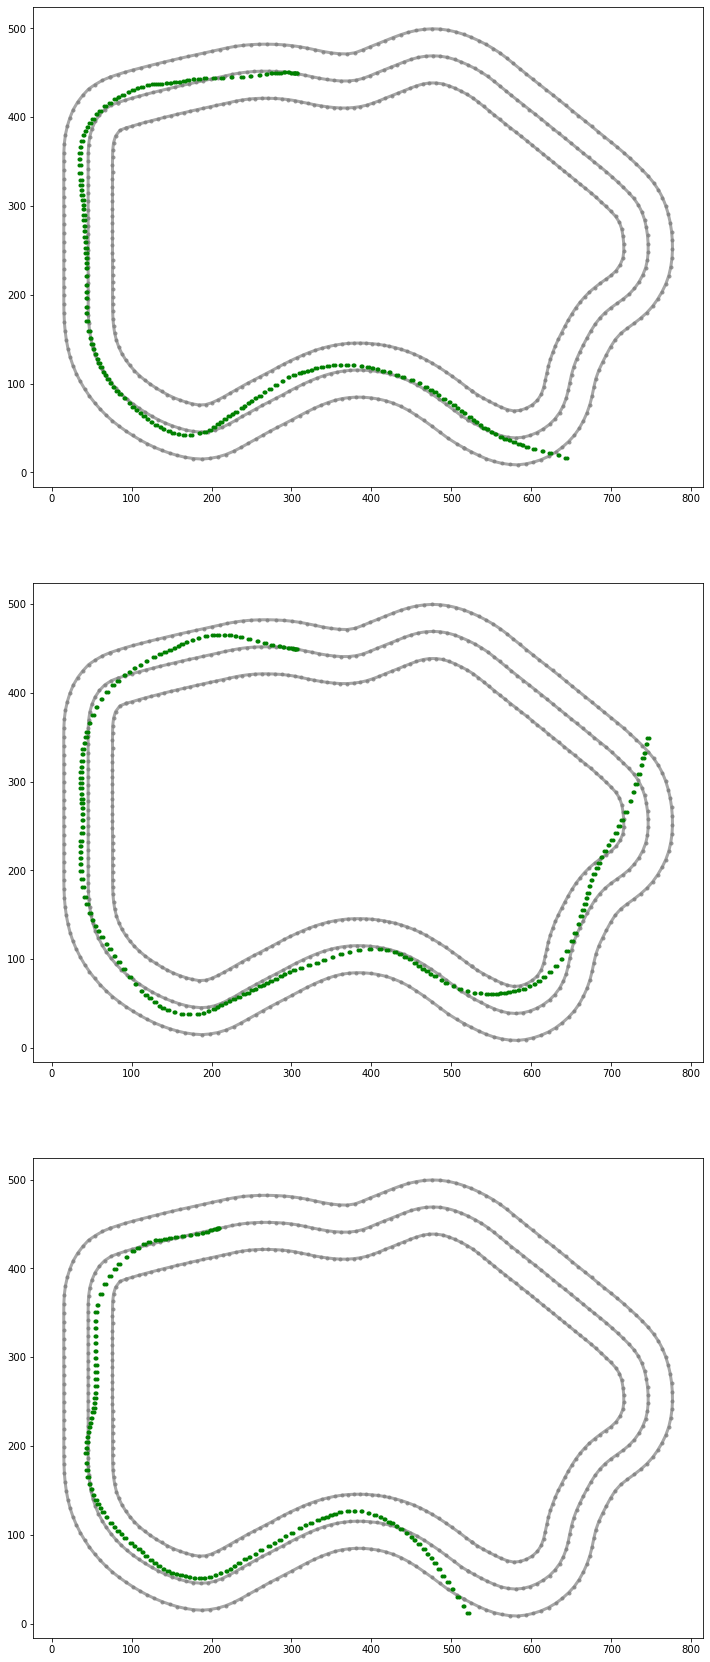

In [73]:
action_map, episode_map, sorted_idx = episode_parser(data_London) 
fig = plot_top_laps(sorted_idx[:], 3)
# None of the model's highest reward earning episodes completed the track.

Number of episodes =  1737


Text(0.5, 0, 'Episode')

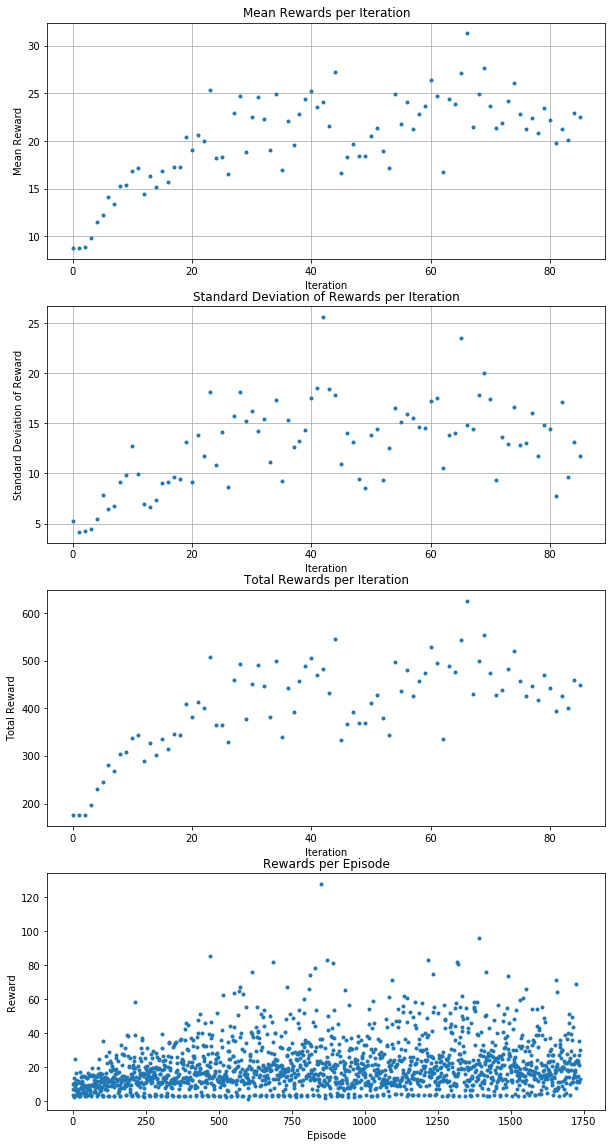

In [74]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_London['episode'])
max_episodes = np.max(df_London['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_London[df_London['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

In [75]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_London, inner_border_London, outer_border_London) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


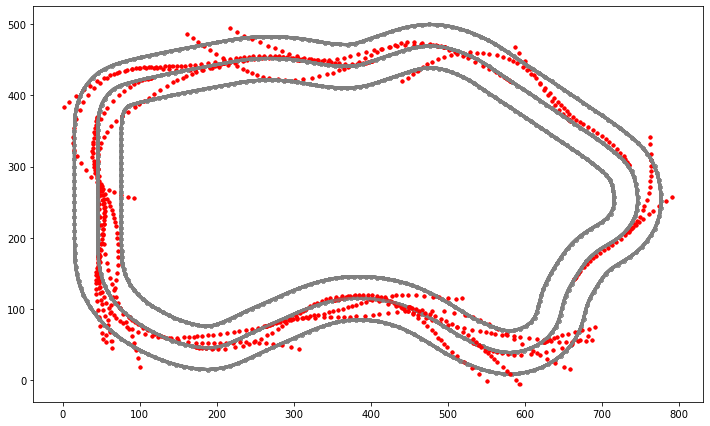

In [76]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_London, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

Episode #750 
155 99
Outer polygon length = 85.41 (meters)
Inner polygon length = 70.15 (meters)
Distance, lap time = 2.11 (meters), 2.11 (sec)
Average throttle, velocity = 4.50 (Gazebo), 1.00 (meters/sec)
###############################################################


Episode #751 
155 99
Outer polygon length = 85.41 (meters)
Inner polygon length = 70.15 (meters)
Distance, lap time = 6.04 (meters), 5.27 (sec)
Average throttle, velocity = 4.76 (Gazebo), 1.15 (meters/sec)
###############################################################


Episode #752 
155 99
Outer polygon length = 85.41 (meters)
Inner polygon length = 70.15 (meters)
Distance, lap time = 5.56 (meters), 4.95 (sec)
Average throttle, velocity = 4.32 (Gazebo), 1.12 (meters/sec)
###############################################################




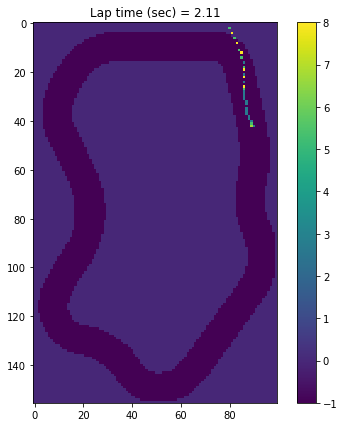

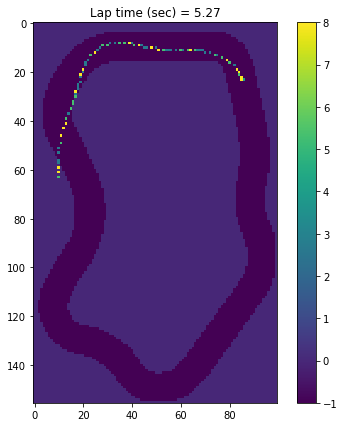

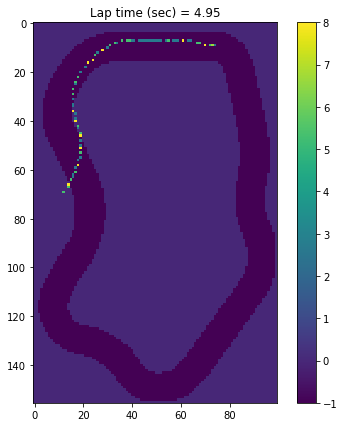

In [77]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_London[df_London['episode'] == e]
    plot_grid_world(episode_df, inner_border_London, outer_border_London, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  The car resumes training in each new episode at or near where it left the track in the prior episode.

# Re-run the above code for the KumoTorakku Model

In [78]:
stream_name = 'sim-3t272k3ps5v7' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the Tokyo Kumo Torakku track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


In [79]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_Tokyo = get_track_waypoints("Tokyo_Training_track") # Fill in track name from above
waypoints_Tokyo.shape

(169, 6)

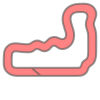

In [80]:
l_center_line = LineString(waypoints_Tokyo[:,0:2])
l_inner_border = LineString(waypoints_Tokyo[:,2:4])
l_outer_border = LineString(waypoints_Tokyo[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [81]:
data_Tokyo = load_data(fname)

In [82]:
df_Tokyo = convert_to_pandas(data_Tokyo, None)
df_Tokyo.head()

iteration  episode  steps       x       y     yaw  steer  throttle  action  \
0          1        0      0  413.67 -239.81 -0.0001   0.00      0.00     0.0   
1          1        0      1  413.66 -239.80 -0.0022   0.17      2.67    12.0   
2          1        0      2  414.08 -239.81 -0.0029   0.52      5.33    19.0   
3          1        0      3  415.43 -239.72  0.0034  -0.52      5.33     1.0   
4          1        0      4  418.43 -239.63  0.0085  -0.52      8.00     2.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.6179                 1      22.63   
1    2.75     0     True    0.6179                 1      22.63   
2    2.20     0     True    0.6362                 1      22.63   
3    2.20     0     True    0.6958                 1      22.63   
4    2.20     0     True    0.8282                 2      22.63   

            timestamp  
0  1563745789.0461829  
1  1563745789.1625488  
2  1563745789.2111104  
3   1563745789.253785  
4  1563745789.3258443

In [83]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_Tokyo['reward'].values.reshape(df_Tokyo['reward'].values.shape[0], 1))
df_Tokyo['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [84]:
df_Tokyo['reward'].min(), df_Tokyo['reward'].max()

(0.0, 1.0)

In [85]:
df_Tokyo.to_csv('Tokyo.csv')         # Save file for later use

In [86]:
def plot_track(df, track_size=(700, 1000), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
    
    track = np.zeros(track_size) 
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_Tokyo, inner_border_Tokyo, outer_border_Tokyo)
    return track

In [87]:
             # identify and rescale waypoints to centimeter scale
center_line_Tokyo = waypoints_Tokyo[:,0:2] *100
inner_border_Tokyo = waypoints_Tokyo[:,2:4] *100
outer_border_Tokyo = waypoints_Tokyo[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_Tokyo['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
else:
    y_offset = abs(y_offset)
center_line_Tokyo[:,1] = center_line_Tokyo[:,1] + y_offset
inner_border_Tokyo[:,1] = inner_border_Tokyo[:,1] + y_offset
outer_border_Tokyo[:,1] = outer_border_Tokyo[:,1] + y_offset

track = plot_track(df_Tokyo, track_size=(700,1000), x_offset=0, y_offset=y_offset)  #Note - for this track, need to pass all parameters
plt.title("Reward distribution for all actions for all iterations - Tokyo Kumo Torakku Track")
img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)

# The model has an interesting reward distribution pattern.  It gains a lot on the straightaways especially in the center.
# But the model does not perform well through the close together turns and when going straight after a sharp turn.


In [88]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_Tokyo[df_Tokyo['iteration'] == iteration_id], track_size=(700,1000), x_offset=0, y_offset=y_offset) # Note-for this track pass parameters
plt.title("Reward distribution for all actions in iteration - Tokyo Kumo Torakku Track" + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model hyperparameter).  


In [89]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_Tokyo)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_Tokyo)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_Tokyo)
        plot_coords(ax, line)
        plot_line(ax, line)

        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100+y_offset, car_y2*100+y_offset], 'g.')  #Note - need to add y_offset for this track
    return fig

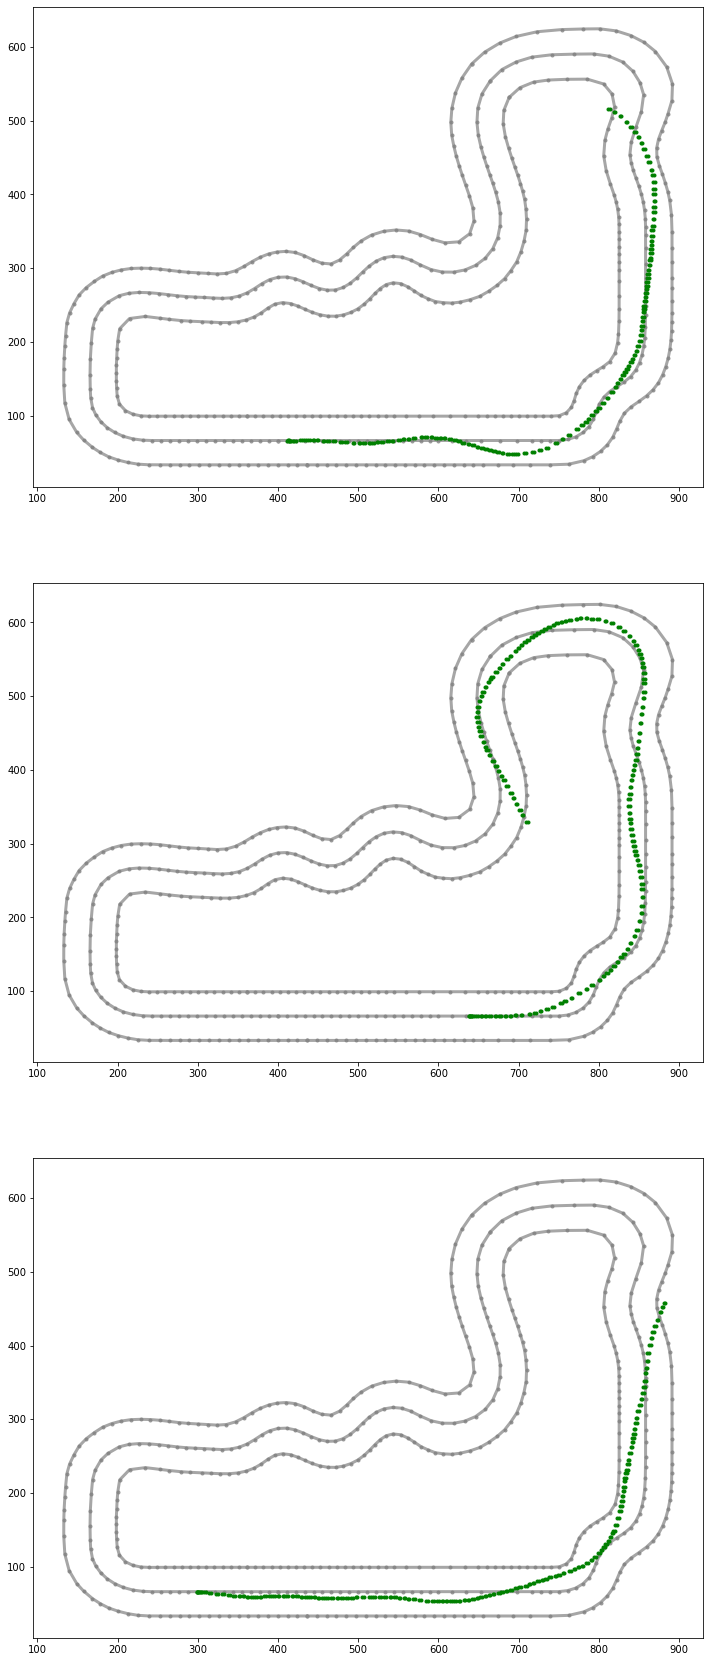

In [90]:
action_map, episode_map, sorted_idx = episode_parser(data_Tokyo) 
fig = plot_top_laps(sorted_idx[:], 3)
# None of the model's highest reward earning episodes completed the track.

Number of episodes =  2117


Text(0.5, 0, 'Episode')

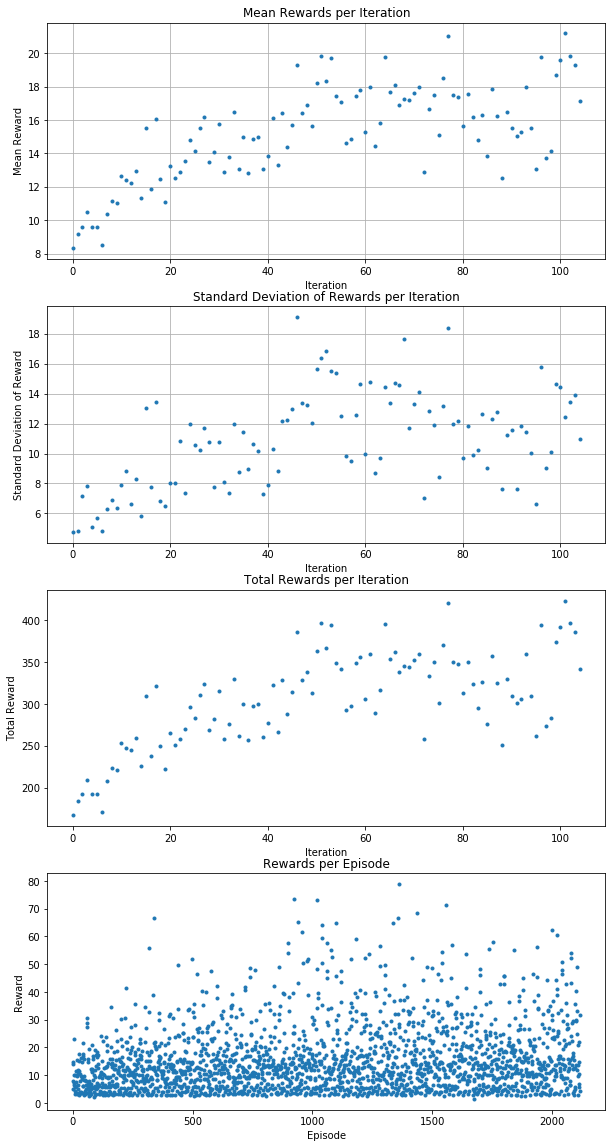

In [91]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_Tokyo['episode'])
max_episodes = np.max(df_Tokyo['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_Tokyo[df_Tokyo['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

In [92]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_Tokyo, inner_border_Tokyo, outer_border_Tokyo) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1+y_offset, car_y2+y_offset], 'r.')              #Note - need to add y_offset for this track

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


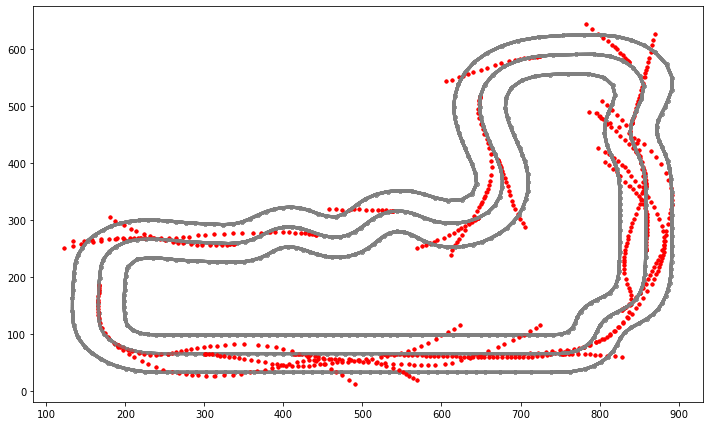

In [93]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_Tokyo, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

In [94]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_Tokyo[df_Tokyo['episode'] == e]
    plot_grid_world(episode_df, inner_border_Tokyo, outer_border_Tokyo, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  The car resumes training in each new episode at or near where it left the track in the prior episode.

Episode #750 
178 124
Outer polygon length = 98.72 (meters)
Inner polygon length = 82.24 (meters)
Distance, lap time = 2.32 (meters), 2.31 (sec)
Average throttle, velocity = 4.19 (Gazebo), 1.00 (meters/sec)
###############################################################


Episode #751 
178 124
Outer polygon length = 98.72 (meters)
Inner polygon length = 82.24 (meters)
Distance, lap time = 2.07 (meters), 1.86 (sec)
Average throttle, velocity = 4.76 (Gazebo), 1.11 (meters/sec)
###############################################################


Episode #752 
178 124
Outer polygon length = 98.72 (meters)
Inner polygon length = 82.24 (meters)
Distance, lap time = 0.94 (meters), 1.22 (sec)
Average throttle, velocity = 4.63 (Gazebo), 0.78 (meters/sec)
###############################################################




# Re-run the above code for the reInvent Model

In [95]:
stream_name = 'sim-0hjtxs4v6r92' 
                                 # This to your simulation application ID from CloudWatch Log Groups /aws/robomaker/SimulationJobs 
                                 # One way to get this is from the Training module on the DeepRacer console for the model being evaluated
                                 # The id is under Resources Simulation job there.  
                                 # This is my evaluation on the AWS track after training on that track
        
fname = 'logs/deepracer-%s.log' %stream_name
cw_utils.download_log(fname, stream_prefix=stream_name)
print('Finished')

Finished


In [96]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" %track_name)
    
waypoints_reinvent = get_track_waypoints("reinvent_base") # Fill in track name from above
waypoints_reinvent.shape

(71, 6)

In [97]:
l_center_line = LineString(waypoints_reinvent[:,0:2])
l_inner_border = LineString(waypoints_reinvent[:,2:4])
l_outer_border = LineString(waypoints_reinvent[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [98]:
data_reinvent = load_data(fname)

In [99]:
df_reinvent = convert_to_pandas(data_reinvent, None)
df_reinvent.head()

iteration  episode  steps       x      y     yaw  steer  throttle  action  \
0          1        0      0  305.00  68.32  0.0004   0.00      0.00     0.0   
1          1        0      1  305.01  68.32  0.0003   0.17      5.33    13.0   
2          1        0      2  305.08  68.29 -0.0028   0.52      8.00    20.0   
3          1        0      3  305.35  68.05 -0.0205   0.35      8.00    17.0   
4          1        0      4  305.83  67.69 -0.0466  -0.17      2.67     6.0   

   reward  done on_track  progress  closest_waypoint  track_len  \
0    1.00     0     True    0.7922                 0      17.67   
1    2.75     0     True    0.7928                 0      17.67   
2    2.20     0     True    0.7967                 0      17.67   
3    2.75     0     True    0.8119                 0      17.67   
4    2.75     0     True    0.8389                 0      17.67   

            timestamp  
0  1563745669.1544888  
1   1563745669.250389  
2  1563745669.2987325  
3  1563745669.3675306  
4  1563745669.4312832

In [100]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df_reinvent['reward'].values.reshape(df_reinvent['reward'].values.shape[0], 1))
df_reinvent['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [101]:
df_reinvent['reward'].min(), df_reinvent['reward'].max()

(0.0, 1.0)

In [102]:
df_reinvent.to_csv("reinvent.csv")        #Save file for later

In [103]:
def plot_track(df, track_size=(550, 800), x_offset=0, y_offset=0):   # Track size needs to be changed based by track
    
    track = np.zeros(track_size) 
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        
        track[y,x] = reward*100                #Increase reward value to show intensity on plot when graphing 
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line_reinvent, inner_border_reinvent, outer_border_reinvent)
    return track

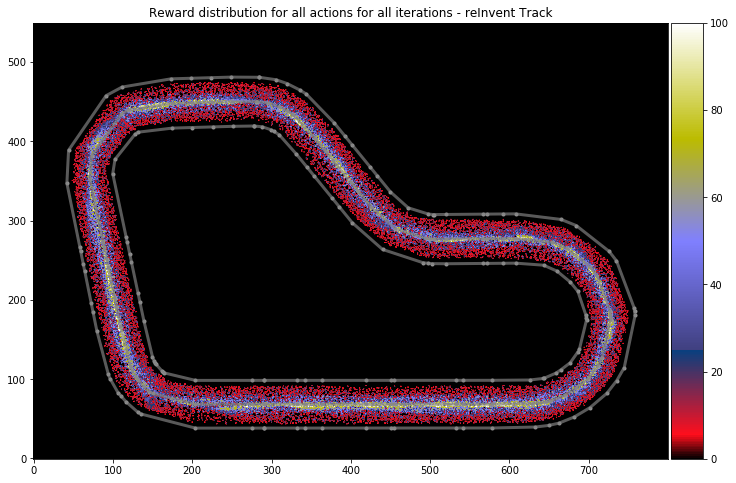

In [104]:
             # identify and rescale waypoints to centimeter scale
center_line_reinvent = waypoints_reinvent[:,0:2] *100
inner_border_reinvent = waypoints_reinvent[:,2:4] *100
outer_border_reinvent = waypoints_reinvent[:,4:6] *100
    
                               # add y_offset to bring everything to the positive axis
y_offset = int(df_reinvent['y'].min())
if y_offset > 0:                                      # if positive, just keep it the same
    y_offset = 0
    y_offset = abs(y_offset)
center_line_reinvent[:,1] = center_line_reinvent[:,1] + y_offset
inner_border_reinvent[:,1] = inner_border_reinvent[:,1] + y_offset
outer_border_reinvent[:,1] = outer_border_reinvent[:,1] + y_offset

track = plot_track(df_reinvent)  
plt.title("Reward distribution for all actions for all iterations - reInvent Track")
img = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
colorbar(img)
# The model gains rewards throughout the track with the center line being the most intense areas.

track = plot_track(df)
plt.title("Reward distribution for all actions for all iterations")
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")
# From the graph below, it seems that the reward level is fairly consistent throughout the track with the exception of turning to the right.
# The model is not gaining many rewards when that happens.

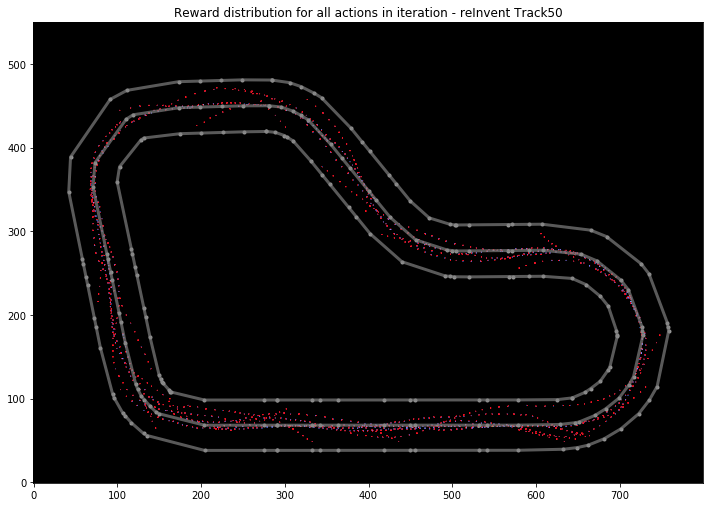

In [105]:
iteration_id = 50                                               # This iteration was selected at random
                                                                # My models had 20 episodes per iteration
                                                                # They trained for 180 minutes.
                                                                # This number should be toward the end of the iterations so it should be
                                                                # near when training stopped
track = plot_track(df_reinvent[df_reinvent['iteration'] == iteration_id])
plt.title("Reward distribution for all actions in iteration - reInvent Track" + str(iteration_id))
im = plt.imshow(track, cmap='gist_stern', interpolation='bilinear', origin="lower")

# This is one interation (#50) which would contain 20 episodes (set by the model  hyperparameter).  
# You can see where the rewards were earned by the red dots.  Mostly along the bottom straightaway adn then around several of the turns.

In [106]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line_reinvent)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border_reinvent)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border_reinvent)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1*100, car_x2*100], [y1*100, car_y2*100], 'g.')
        
    return fig

In [107]:
action_map, episode_map, sorted_idx = episode_parser(data_reinvent) 
fig = plot_top_laps(sorted_idx[:], 3)
# None of the model's highest reward earning episodes completed the track.

In [108]:
REWARD_THRESHOLD = 100   # This is set so that on the graph, rewards above this threshold display in a different color on the graphs

# reward graph per episode
min_episodes = np.min(df_reinvent['episode'])
max_episodes = np.max(df_reinvent['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df_reinvent[df_reinvent['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()
total_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == 20:                                             # This needs to correspond to episodes per iteration hyperparameter
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        total_reward_per_iteration.append(np.sum(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(411)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Mean Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(412)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')
ax.set_title('Standard Deviation of Rewards per Iteration')
ax.set_ylabel('Standard Deviation of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(413)
ax.plot(np.arange(len(total_reward_per_iteration)), total_reward_per_iteration, '.')
ax.set_title('Total Rewards per Iteration')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Iteration')

ax = fig.add_subplot(414)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_title('Rewards per Episode')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')

Number of episodes =  1659


Text(0.5, 0, 'Episode')

In [109]:
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line_reinvent, inner_border_reinvent, outer_border_reinvent) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

C:\Users\sue\Anaconda3\envs\DeepRacer\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


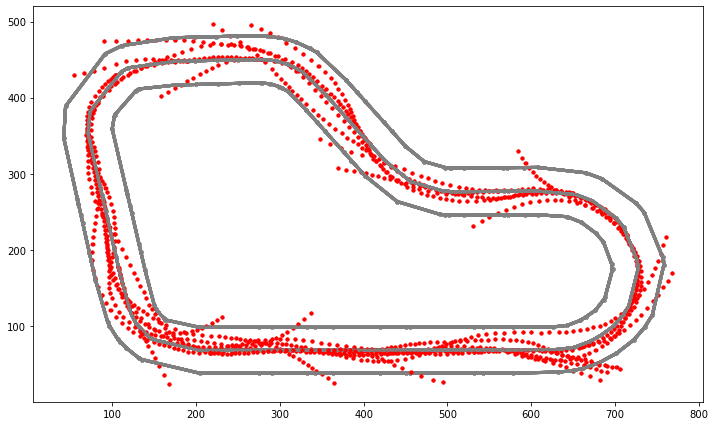

In [110]:
iteration_id = 50

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df_reinvent, E=i)
# This iteration would be comprised of 20 episodes.  The car re-enters the track near where it went off the track to resume the training 
# if it does not complete the track in the episode.

Episode #750 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 4.62 (meters), 3.89 (sec)
Average throttle, velocity = 4.88 (Gazebo), 1.19 (meters/sec)
###############################################################


Episode #751 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 2.02 (meters), 2.08 (sec)
Average throttle, velocity = 4.33 (Gazebo), 0.97 (meters/sec)
###############################################################


Episode #752 
151 96
Outer polygon length = 78.23 (meters)
Inner polygon length = 63.13 (meters)
Distance, lap time = 4.13 (meters), 3.08 (sec)
Average throttle, velocity = 5.11 (Gazebo), 1.34 (meters/sec)
###############################################################




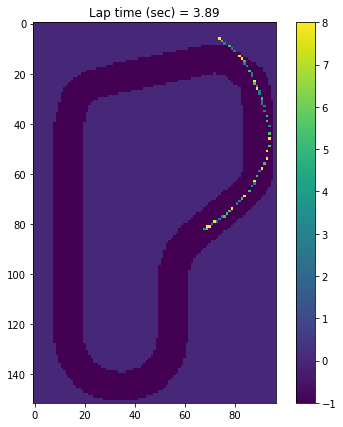

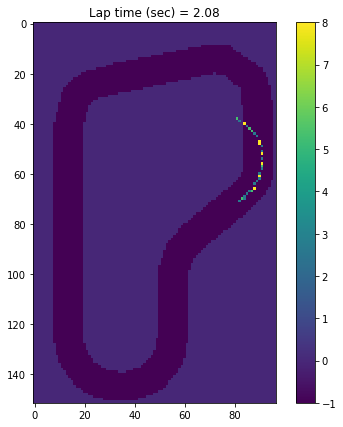

In [111]:
N_EPISODES = 3 
START_EPISODE = 750                                                 # Look at the training model starting with this episode

for e in range(START_EPISODE, START_EPISODE+N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = df_reinvent[df_reinvent['episode'] == e]
    plot_grid_world(episode_df, inner_border_reinvent, outer_border_reinvent, scale=5.0, plot=True)      # Call to log_analysis.py file function
    print ("###############################################################\n\n")
# Through the graphs, you can see the speed the car is traveling in addition to the path of the car during the specified episode.
# This is 3 consecutive episodes.  The car resumes training in each new episode at or near where it left the track in the prior episode.

# Code below here is not being used, but is included for future analysis capability

# Model CSV Analysis
- Prior to running this chunk of the notebook, make sure that you have done the following 2 steps:
- Download the models from the console AWS DeepRacer > Reinforcement learning > TrainingJobName > Download Model
- Unzip the tar.gz files and put it in the intermediate_checkpoint folder
- This is another way to get the episode and iteration data that can also be obtained from the logs vs the tar file

In [ ]:
fname = 'intermediate_checkpoint/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname)

In [ ]:
df_csv.columns

In [ ]:
title = "Rewards in Each Training Iteration"
df_csv.plot(x='Training Iter', y='Training Reward', style='.', 
        title=title)

In [ ]:
title = "Length of Each Episode"
df_csv['Episode Length'].plot(title=title)